<a href="https://colab.research.google.com/github/Ifeoluwa-hub/Social-Media-Sentiment-Analysis-of-the-EPL/blob/main/Sentiment_Analysis_(EPL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Analyzing Social Media Sentiment of the English Premier League**







In [1]:
# import the libraries
import tweepy 
from textblob import TextBlob
import re
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Twitter API Credentials
log = pd.read_csv(r"/content/Twitter API.csv")

consumerKey = log['key'][0]
consumerSecret = log['key'][1]
accessToken = log['key'][2]
accessSecret = log['key'][3]

# Create the Authentication Object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

# Set the access token and access secret
authenticate.set_access_token(accessToken, accessSecret)

api = tweepy.API(authenticate, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [3]:
#Spool tweets 

text_query = 'EPL'
count = 5000
try:
    tweets = tweepy.Cursor(api.search,q=text_query, lang= 'en', since = "2022-08-06",
                           tweet_mode = "extended").items(count)
    tweets_list = [[tweet.user.screen_name,tweet.user.location,tweet.user.followers_count,
                    tweet.retweet_count,tweet.created_at, tweet.id, tweet.full_text] for tweet in tweets]
    tweets_df = pd.DataFrame(tweets_list)
    tweets_df.rename(columns = {0:'User', 1:'location',2:'Followers',3:'retweets',4:'date_created',
                               5:'tweet_id',6:'text'}, inplace = True)

except BaseException as e:
    print('failed on_status,',str(e))
    time.sleep(3)


tweets_df.rename(columns = {0:'user', 1:'location',2:'followers',3:'retweets',4:'date_created',
                               5:'tweet_id',6:'text'}, inplace = True)
tweets_df

,User,location,Followers,retweets,date_created,tweet_id,text
0,MarkSus62116387,Mauritania,65,1,2022-09-01 11:27:44,1565300367528787968,RT @FinancialSs: Most expensive #football defe...
1,Miki_Mireku28,"Greater Accra, Ghana",88,0,2022-09-01 11:27:41,1565300355931508737,@CFCPys @Nathan_Gissing Well I hope they don’t...
2,BasilProudly,Nigeria,814,0,2022-09-01 11:27:40,1565300351711993859,Isak Who Only Manage To Score Against Elche in...
3,Justin__aries,,21,1059,2022-09-01 11:27:23,1565300281860055040,RT @Boboye_Ak: Haaland has scored more EPL hat...
4,MickyCarlos,"Buckingham, England",3678,1,2022-09-01 11:27:22,1565300276772356102,RT @Lesfabb: If Haaland was popping in Laliga ...
...,...,...,...,...,...,...,...
4995,putuadhika27,Bandung,273,0,2022-09-01 04:05:52,1565189167692148737,"Gile Halaand, back to back hattrick di epl 😶‍🌫️"
4996,Khau_Mokhele,"Alberton, South Africa",456,47,2022-09-01 04:05:39,1565189113229230080,RT @kojodarkoo: Erling Haaland and Gabriel Jes...
4997,AndileBD,"Kempton Park, South Africa",5337,112,2022-09-01 04:04:22,1565188792574771201,RT @Yanks_Uchiha: Halaand when people said he’...
4998,bridgecityfirm,"Saskatoon, Saskatchewan",796,1,2022-09-01 04:04:14,1565188756558479361,RT @LeeKormish: A real gem of an silent auctio...


In [4]:
# Remove duplicates
tweets_df.drop_duplicates(subset='text', keep ='first',inplace=True)
tweets_df.head()

,User,location,Followers,retweets,date_created,tweet_id,text
0,MarkSus62116387,Mauritania,65,1,2022-09-01 11:27:44,1565300367528787968,RT @FinancialSs: Most expensive #football defe...
1,Miki_Mireku28,"Greater Accra, Ghana",88,0,2022-09-01 11:27:41,1565300355931508737,@CFCPys @Nathan_Gissing Well I hope they don’t...
2,BasilProudly,Nigeria,814,0,2022-09-01 11:27:40,1565300351711993859,Isak Who Only Manage To Score Against Elche in...
3,Justin__aries,,21,1059,2022-09-01 11:27:23,1565300281860055040,RT @Boboye_Ak: Haaland has scored more EPL hat...
4,MickyCarlos,"Buckingham, England",3678,1,2022-09-01 11:27:22,1565300276772356102,RT @Lesfabb: If Haaland was popping in Laliga ...


In [5]:
tweets_df.shape

(3293, 7)

**Data** **Cleaning**

In [18]:
# Define a function that removes links, symbols etc
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r':', '', re.sub('\n\n', '', text))
    short_text  = [w for w in text.split() if len(w) > 3]
    text = " ".join(short_text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [20]:
tweets_df['text'] = tweets_df.text.apply(clean_text)
tweets_df.head()

,User,location,Followers,retweets,date_created,tweet_id,text
0,MarkSus62116387,Mauritania,65,1,2022-09-01 11:27:44,1565300367528787968,Most expensive football defenders time Chelsea...
1,Miki_Mireku28,"Greater Accra, Ghana",88,0,2022-09-01 11:27:41,1565300355931508737,_Gissing Well hope sanction approve move club ...
2,BasilProudly,Nigeria,814,0,2022-09-01 11:27:40,1565300351711993859,Isak Only Manage Score Against Elche Liga Scor...
3,Justin__aries,,21,1059,2022-09-01 11:27:23,1565300281860055040,Haaland scored tricks last days Marcus Rashfor...
4,MickyCarlos,"Buckingham, England",3678,1,2022-09-01 11:27:22,1565300276772356102,Haaland popping Laliga talk liga easy Love man...


**Exploratory Data Analysis**

In [21]:
# Get the subjectivity and polarity of tweets
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [22]:
tweets_df['subjectivity'] = tweets_df['text'].apply(get_subjectivity)
tweets_df['polarity'] = tweets_df['text'].apply(get_polarity)
tweets_df.head()

,User,location,Followers,retweets,date_created,tweet_id,text,subjectivity,polarity
0,MarkSus62116387,Mauritania,65,1,2022-09-01 11:27:44,1565300367528787968,Most expensive football defenders time Chelsea...,0.633333,-0.166667
1,Miki_Mireku28,"Greater Accra, Ghana",88,0,2022-09-01 11:27:41,1565300355931508737,_Gissing Well hope sanction approve move club ...,0.125000,0.000000
2,BasilProudly,Nigeria,814,0,2022-09-01 11:27:40,1565300351711993859,Isak Only Manage Score Against Elche Liga Scor...,1.000000,0.000000
3,Justin__aries,,21,1059,2022-09-01 11:27:23,1565300281860055040,Haaland scored tricks last days Marcus Rashfor...,0.066667,0.000000
4,MickyCarlos,"Buckingham, England",3678,1,2022-09-01 11:27:22,1565300276772356102,Haaland popping Laliga talk liga easy Love man...,0.716667,0.466667


In [23]:
# Create a function to compute the negative, neutral and positive tweets
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [24]:
tweets_df['analysis'] = tweets_df['polarity'].apply(getAnalysis)
tweets_df.head()

,User,location,Followers,retweets,date_created,tweet_id,text,subjectivity,polarity,analysis
0,MarkSus62116387,Mauritania,65,1,2022-09-01 11:27:44,1565300367528787968,Most expensive football defenders time Chelsea...,0.633333,-0.166667,Negative
1,Miki_Mireku28,"Greater Accra, Ghana",88,0,2022-09-01 11:27:41,1565300355931508737,_Gissing Well hope sanction approve move club ...,0.125000,0.000000,Neutral
2,BasilProudly,Nigeria,814,0,2022-09-01 11:27:40,1565300351711993859,Isak Only Manage Score Against Elche Liga Scor...,1.000000,0.000000,Neutral
3,Justin__aries,,21,1059,2022-09-01 11:27:23,1565300281860055040,Haaland scored tricks last days Marcus Rashfor...,0.066667,0.000000,Neutral
4,MickyCarlos,"Buckingham, England",3678,1,2022-09-01 11:27:22,1565300276772356102,Haaland popping Laliga talk liga easy Love man...,0.716667,0.466667,Positive


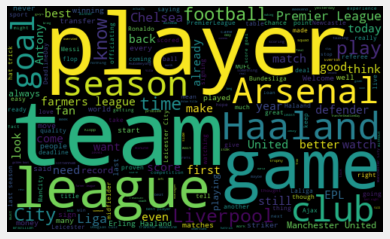

In [25]:
# Check distribution of sentiment by plotting a wordcloud
allwords = ' '.join([twts for twts in tweets_df['text']])
WordCloud = WordCloud(width = 500, height = 300, random_state=21, max_font_size=119).generate(allwords)
plt.imshow(WordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

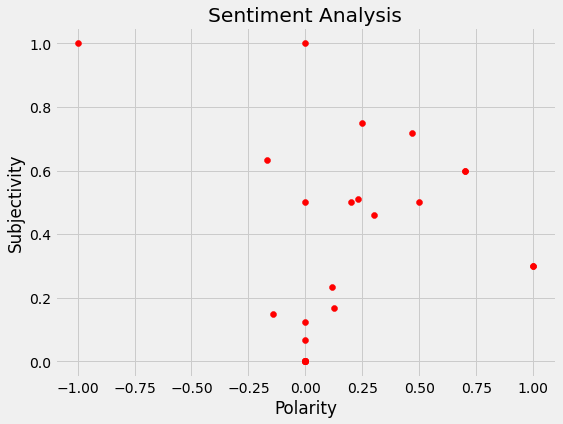

In [26]:
#Plt the polarity and subjectivity

plt.figure(figsize=(8,6))
try:
  for i in range(0, tweets_df.shape[0]):
    plt.scatter(tweets_df['polarity'][i], tweets_df['subjectivity'][i], color='red') 
except KeyError:
  pass
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show();

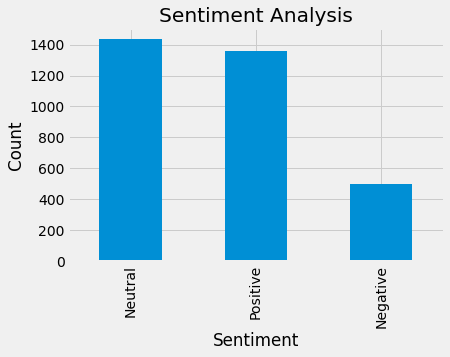

In [27]:
# plot the count of sentiments
tweets_df['analysis'].value_counts()
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
tweets_df['analysis'].value_counts().plot(kind='bar');

In [28]:
tweets_df['label'] = tweets_df['analysis'].apply(lambda x: 1 if x == 'Negative' else(0 if x=='Neutral' else 2))
tweets_df.head()

,User,location,Followers,retweets,date_created,tweet_id,text,subjectivity,polarity,analysis,label
0,MarkSus62116387,Mauritania,65,1,2022-09-01 11:27:44,1565300367528787968,Most expensive football defenders time Chelsea...,0.633333,-0.166667,Negative,1
1,Miki_Mireku28,"Greater Accra, Ghana",88,0,2022-09-01 11:27:41,1565300355931508737,_Gissing Well hope sanction approve move club ...,0.125000,0.000000,Neutral,0
2,BasilProudly,Nigeria,814,0,2022-09-01 11:27:40,1565300351711993859,Isak Only Manage Score Against Elche Liga Scor...,1.000000,0.000000,Neutral,0
3,Justin__aries,,21,1059,2022-09-01 11:27:23,1565300281860055040,Haaland scored tricks last days Marcus Rashfor...,0.066667,0.000000,Neutral,0
4,MickyCarlos,"Buckingham, England",3678,1,2022-09-01 11:27:22,1565300276772356102,Haaland popping Laliga talk liga easy Love man...,0.716667,0.466667,Positive,2


In [29]:
tweets_df.shape

(3293, 11)

In [30]:
tweets_df.to_csv('/content/labelled data.csv')